## About the project:
approach with a 2 layered ml system
1. 1st layer: focus on designing a ml model, which of the potential customers we should make calls to (haven't make any calls yet, can't use any call-related feature ex, duration, campaign, maonth othe call, etc)
- focus on reducing the # of calls w/o loosing a lot of subscribers, which means we want to focus on recall for class 0, capture as many
2. 2nd layer: we should design another ml model, which is predict which of the customers we should keep calling to (since calls have been made, I can use call-related data, actually predict which of the customers we should keep calling to make calls to)
- focus on precision on class 1, focus on current subscribers, how to prioritize those customers, identify those customers
- it will use the output of the 1st model(<-- which of the class should be made to, we can focus on which of the potential customers we should keep reaching out)
-

3rd part.
- train unsupervised model, to understand who those customers are,
- filtered the non-subscribers
- goal is to segment the subscribers

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# Read dataset
df = pd.read_csv('/content/drive/MyDrive/Apziva/2ndProject/term-deposit-marketing-2020.csv')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


## Data Description

Features: <br>
- age : age of customer (numeric)
- job : type of job (categorical)
- marital : marital status (categorical)
- education (categorical)
- default: has credit in default? (binary)
- balance: average yearly balance, in euros (numeric)
- housing: has a housing loan? (binary)
- loan: has personal loan? (binary)
- contact: contact communication type (categorical)
- day: last contact day of the month (numeric)
- month: last contact month of year (categorical)
- duration: last contact duration, in seconds (numeric)
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target): <br>
y - has the client subscribed to a term deposit? (binary)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


### Exploratory Data Analysis


#### 1. Summary Statistics

In [ ]:
# Summary statistics for numerical columns
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [ ]:
# Step 1: Convert categorical columns to numeric (label encoding)
df_encoded = df.copy()
categorical_columns = df_encoded.select_dtypes(include=['object']).columns

In [ ]:
# Distribution of categorical columns
for col in categorical_columns:
    print(df[col].value_counts())

job
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: count, dtype: int64
marital
married     24386
single      10889
divorced     4725
Name: count, dtype: int64
education
secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: count, dtype: int64
default
no     39191
yes      809
Name: count, dtype: int64
housing
yes    24031
no     15969
Name: count, dtype: int64
loan
no     33070
yes     6930
Name: count, dtype: int64
contact
cellular     24914
unknown      12765
telephone     2321
Name: count, dtype: int64
month
may    13532
jul     6380
aug     5215
jun     4734
nov     3598
apr     2718
feb     2296
jan     1176
mar      258
oct       80
dec       13
Name: count, dtype: int64
y
no     37104
yes     2896
Name: count, dtype: int64


#### 2. Missing Values Analysis & Outlier Detection

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64


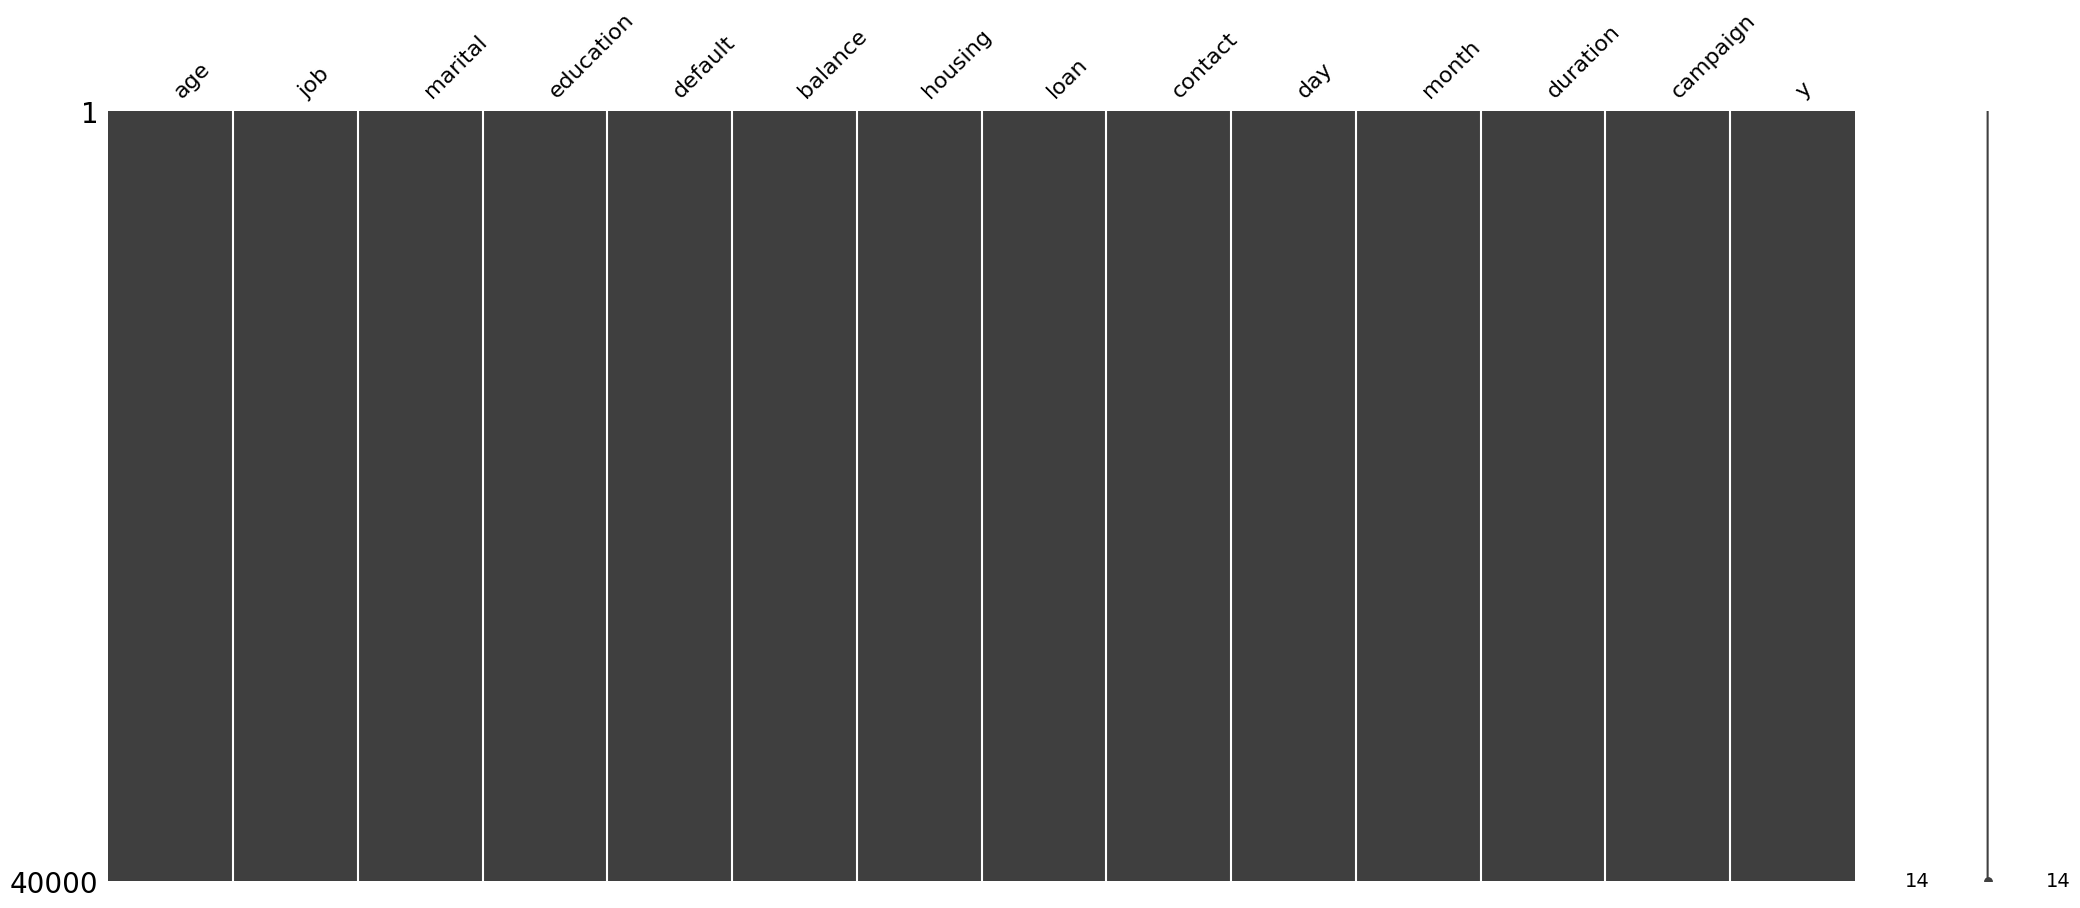

In [ ]:
# Check for missing values
print(df.isnull().sum())

# Visualizing missing data
import missingno as msno
msno.matrix(df)
plt.show()

In [ ]:
from scipy import stats

# Z-Score method
z_scores = stats.zscore(df.select_dtypes(include=['float64', 'int64']))
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3).all(axis=1)
df_outliers = df[outliers]
df_outliers   # I find no outliers

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y


#### 3. Data Visualization
- Histograms:
- Box Plots:
- Count Plots:
- Bar plots:

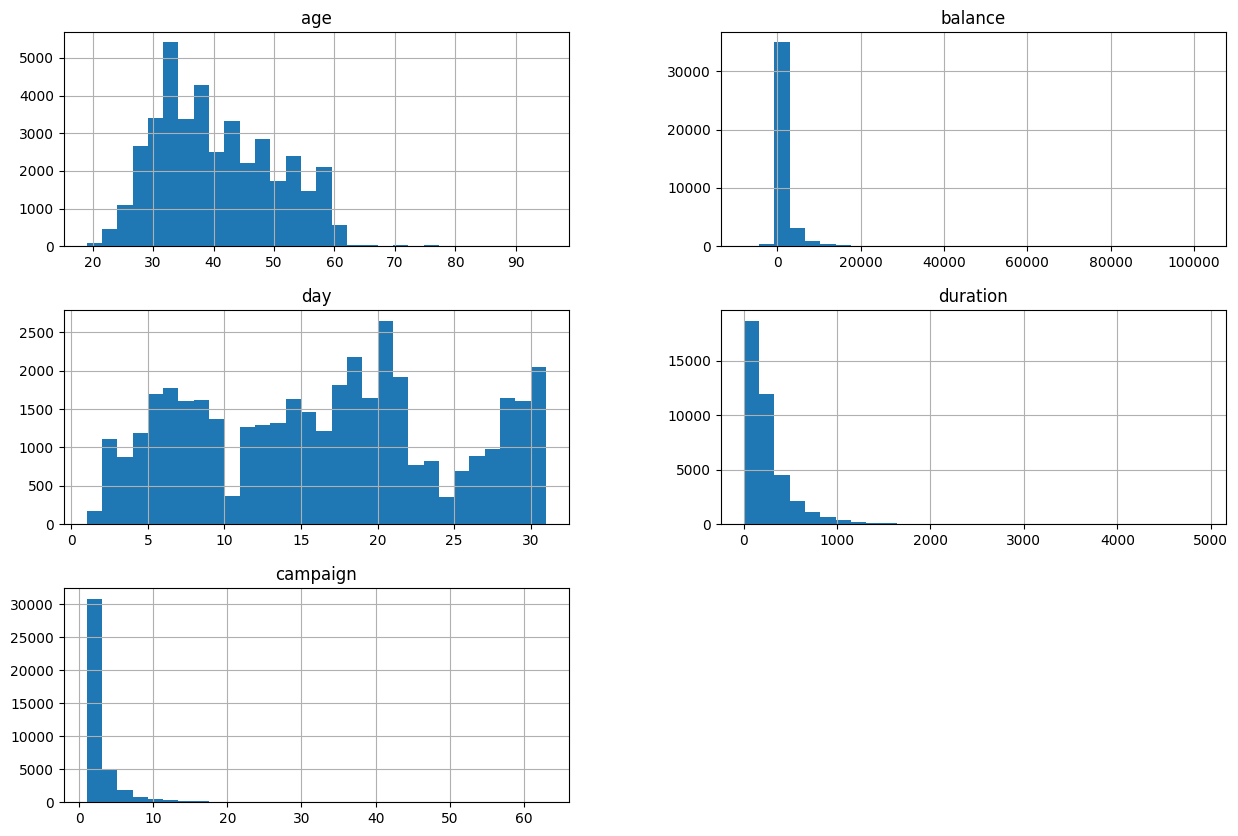

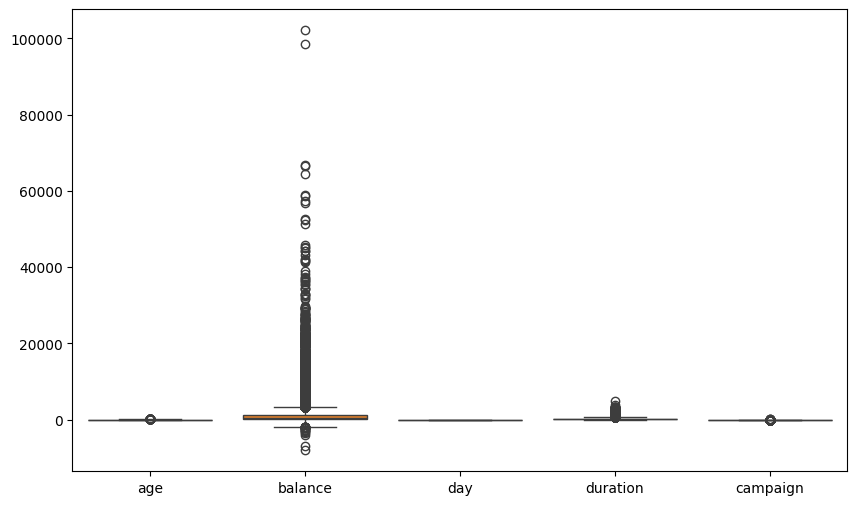

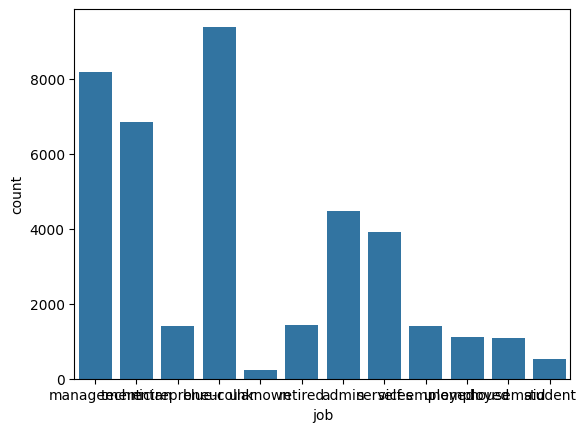

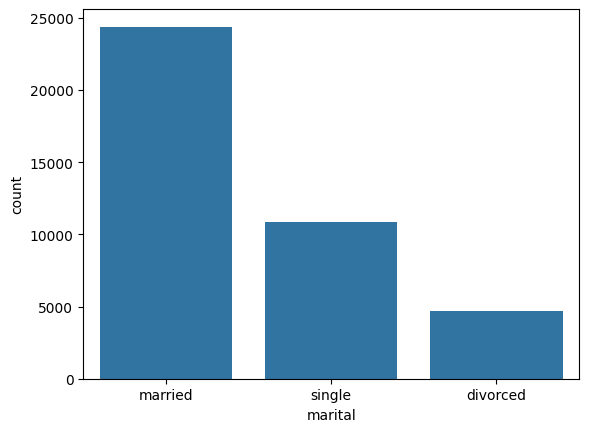

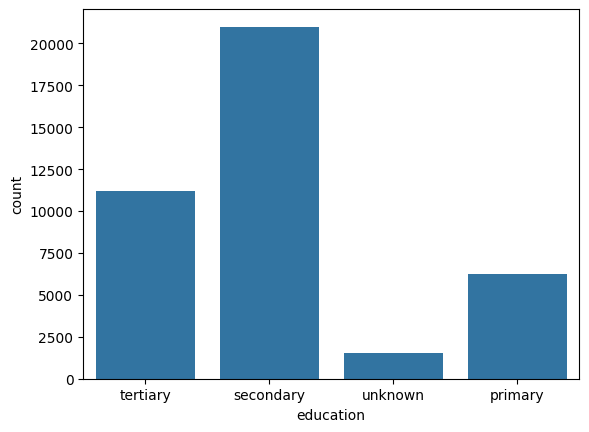

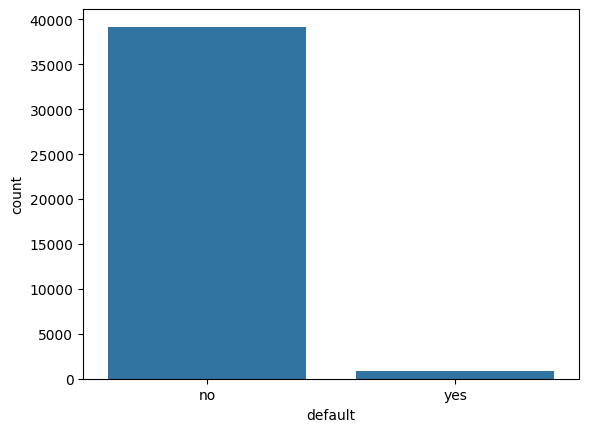

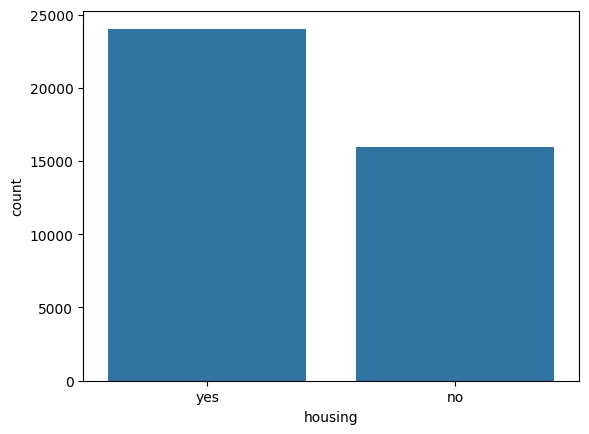

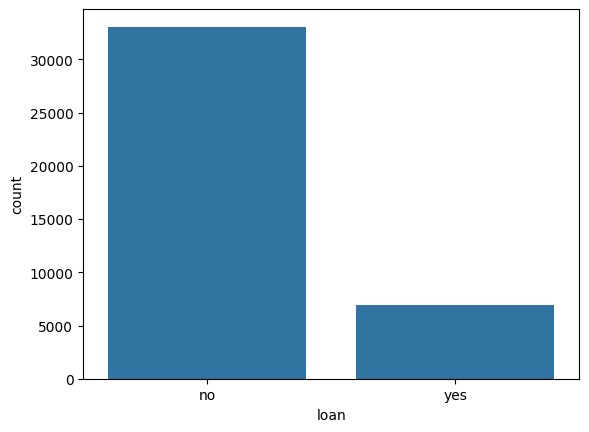

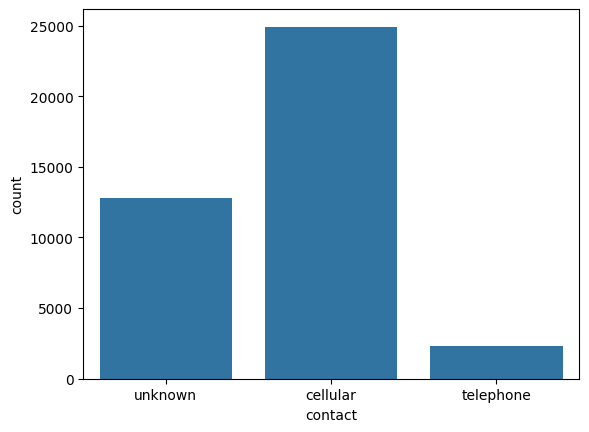

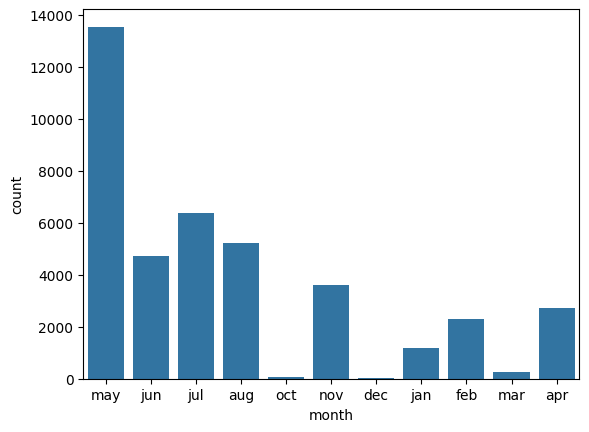

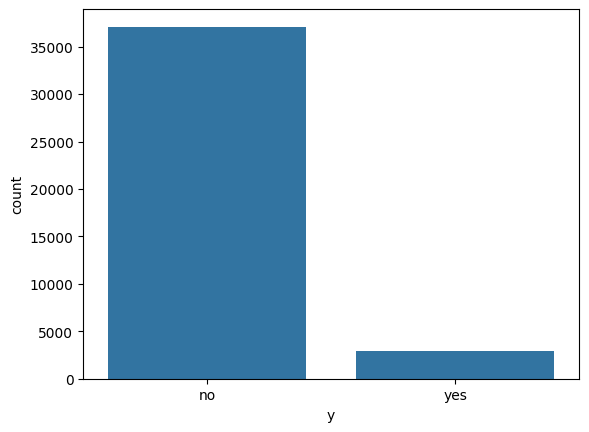

In [ ]:
# Histograms
df.hist(bins=30, figsize=(15,10))
plt.show()

# Box plots
plt.figure(figsize=(10,6))
sns.boxplot(data=df_encoded)
plt.show()

# Count plots for categorical variables
for col in categorical_columns:
    sns.countplot(x=col, data=df)
    plt.show()

#### 4. Feature Relationships
- Correlation Heatmap
- Scatter Plots
- Pair Plot

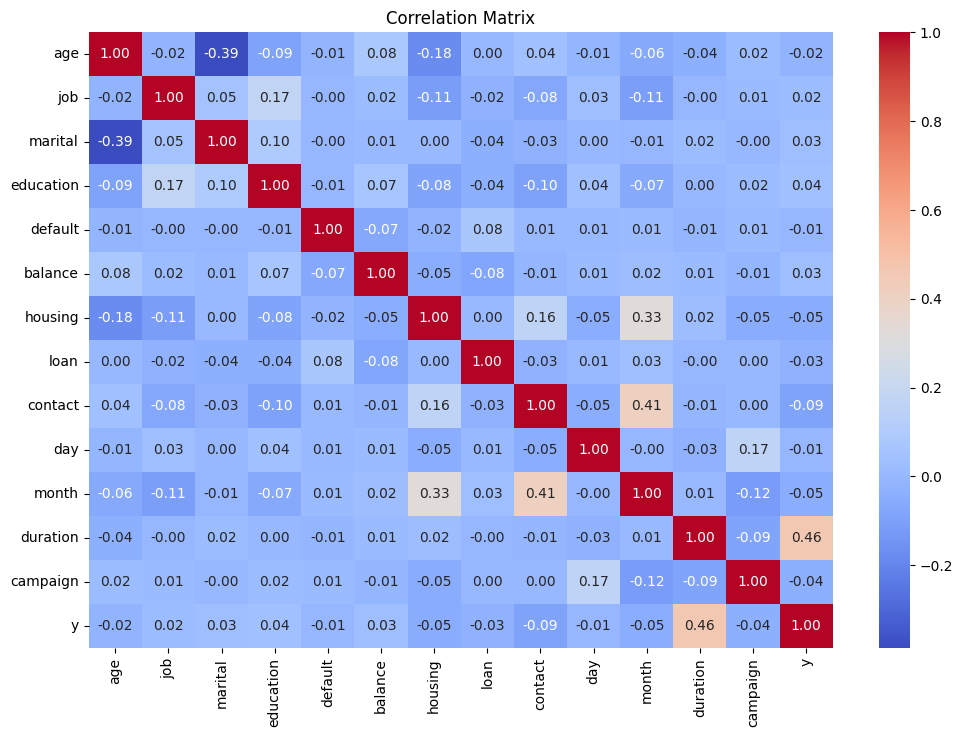

In [ ]:
for col in categorical_columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Step 2: Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Display the correlation matrix
# print(correlation_matrix)

# If you want a heatmap visualization of the correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

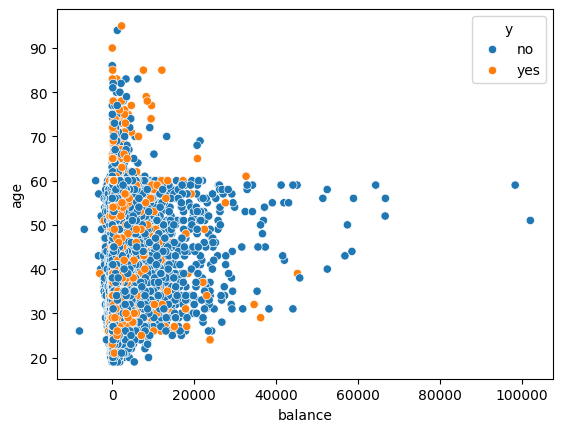

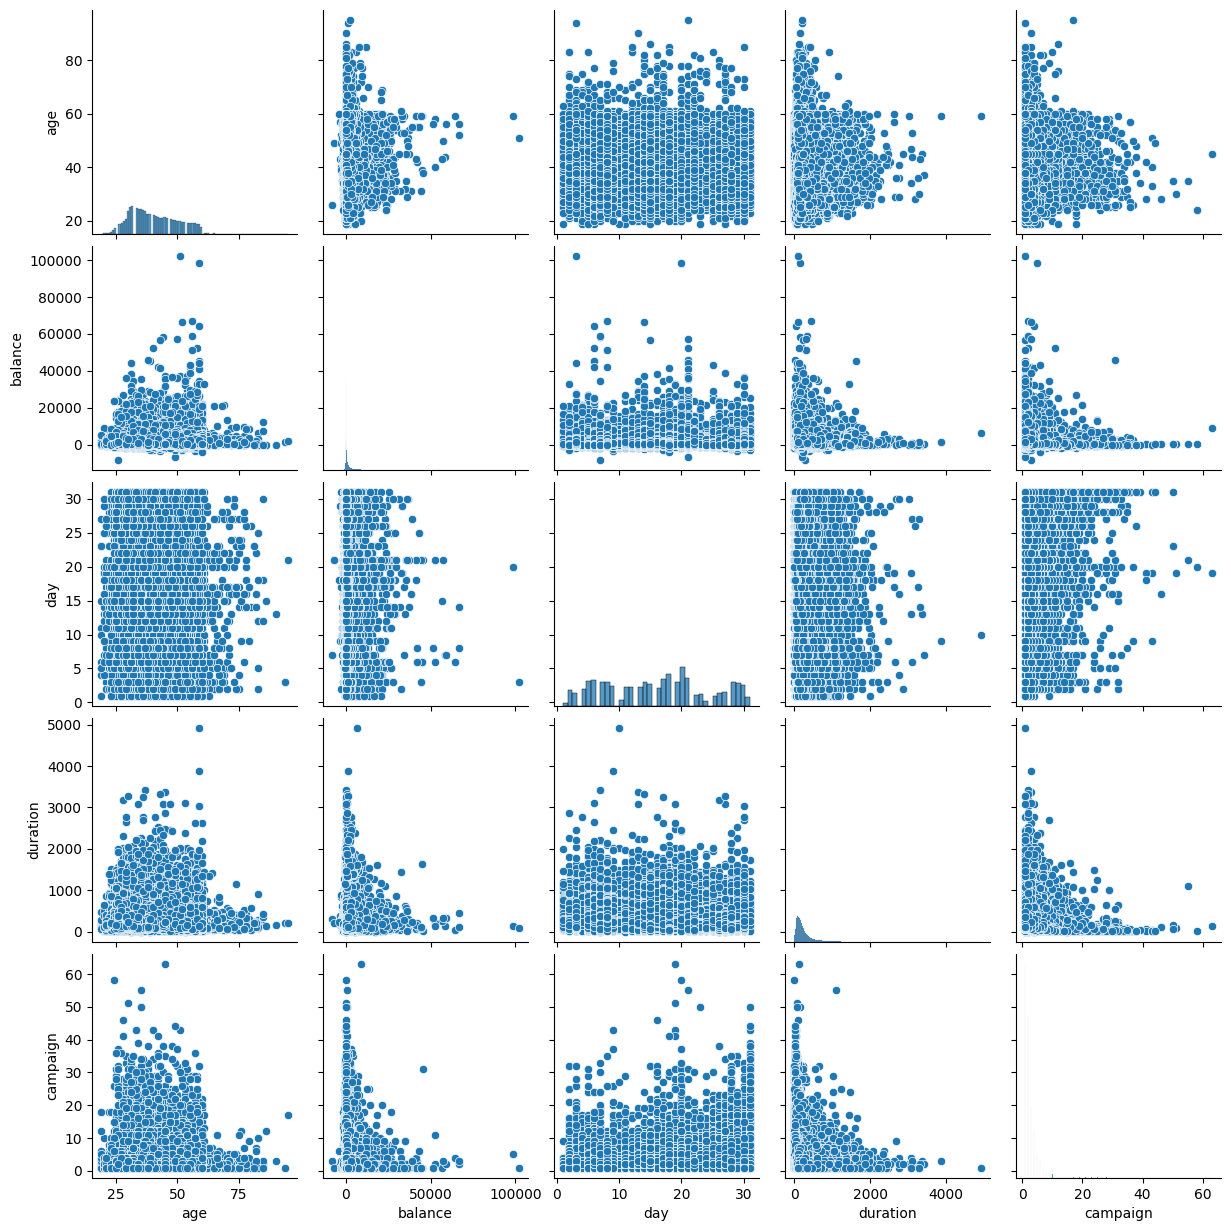

In [ ]:
# Scatter plot  - only balance and age
sns.scatterplot(x='balance', y='age', hue='y', data=df)
plt.show()

# Pair plot
sns.pairplot(df_encoded)
plt.show()

#### 5. Target Variable
- Distribution of Target Variable:
- Groupby Analysis:

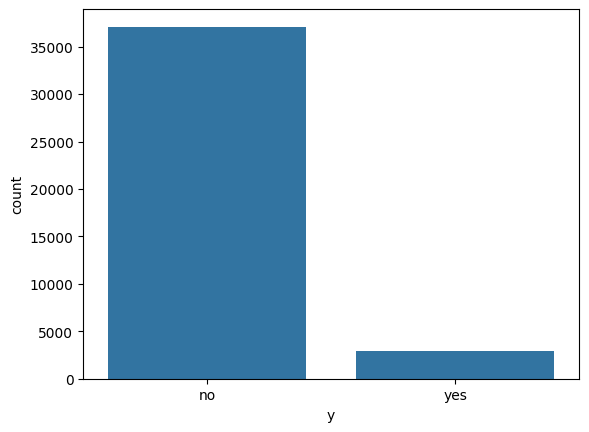

       age    job  marital  education  default  balance  housing   loan  \
y                                                                         
no   37104  37104    37104      37104    37104    37104    37104  37104   
yes   2896   2896     2896       2896     2896     2896     2896   2896   

     contact    day  month  duration  campaign  age_group  
y                                                          
no     37104  37104  37104     37104     37104      37104  
yes     2896   2896   2896      2896      2896       2896  


In [ ]:
# Distribution of the target variable
sns.countplot(x='y', data=df)
plt.show()

# Groupby analysis
print(df.groupby('y').count())


# there are many 'no's, so this is imbalanced.
# Recommendations:
# 1. to use Random Undersampling for the measurity class <-- 1st task
# 2. create another version of dataset: use smote for the minority class , which is called the oversampling
# 3. Try smoteenn, which will do both oversampling and undersampling at the same time for the imblanaced data
# 4. Use Pycaret, compare models functionality: quite similar to lazy classifier but to get exposed to another tool which is popular in the industry
# Imbalanced data could be the issue. See if it can improve , also add RandomSearch and strategies I've done for the 1st project

#### 6. Feature Engineering

In [ ]:
# Example: Binning age into categorie
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 100], labels=[0, 1, 2])
df['age_group']

,age_group
0,2
1,1
2,1
3,1
4,1
...,...
39995,2
39996,0
39997,2
39998,1


## Models - 3 layers

### 1st Layer:

In [ ]:
# Step 1: Feature Selection & Encoding (Exclude call-related features and encode categorical features)
X = df.drop(columns=['duration', 'campaign', 'day', 'month', 'y'])
y = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Import necessary library for encoding
!pip install scikit-learn
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Store the encoders for later use if needed

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 3: Model Training (Random Forest Classifier)
model_1 = RandomForestClassifier(class_weight='balanced', random_state=42)
model_1.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Step 1: Feature Selection (Include call-related features)
X_layer2 = df.drop(columns=['y'])  # Use all features
y_layer2 = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Step 2: Filter the Data Based on the 1st Model's Predictions
# Select only the features used in the first model for prediction
X_layer2_for_prediction = X_layer2[X_train.columns]

# Encode categorical features in X_layer2_for_prediction using the same encoders from the first model
for col in categorical_cols:
    X_layer2_for_prediction[col] = label_encoders[col].transform(X_layer2_for_prediction[col])

predicted_calls = model_1.predict(X_layer2_for_prediction) == 0  # Potential subscribers identified by the 1st model

# Encode categorical features in X_layer2 BEFORE filtering
for col in categorical_cols:
    X_layer2[col] = label_encoders[col].transform(X_layer2[col])  # Encode before filtering

X_layer2_filtered = X_layer2[predicted_calls] # Use all features for the second model
y_layer2_filtered = y_layer2[predicted_calls]

# Handle 'month' encoding if it's present and needs encoding
if 'month' in X_layer2_filtered.columns:
    # Fit a new LabelEncoder for 'month' if it wasn't encoded before
    le_month = LabelEncoder()
    X_layer2_filtered['month'] = le_month.fit_transform(X_layer2_filtered['month'])

# Step 3: Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_layer2_filtered, y_layer2_filtered, test_size=0.3, random_state=42, stratify=y_layer2_filtered)

# Step 4: Model Training (focus on precision for class 1)
model_2 = RandomForestClassifier(class_weight='balanced', random_state=42)
model_2.fit(X_train2, y_train2)

# Step 5: Prediction and Evaluation
y_pred2 = model_2.predict(X_test2)
print(classification_report(y_test2, y_pred2, target_names=['No', 'Yes']))

<ipython-input-56-13b990bd11d3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_layer2_for_prediction[col] = label_encoders[col].transform(X_layer2_for_prediction[col])
<ipython-input-56-13b990bd11d3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_layer2_for_prediction[col] = label_encoders[col].transform(X_layer2_for_prediction[col])
<ipython-input-56-13b990bd11d3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

              precision    recall  f1-score   support

          No       0.98      1.00      0.99     11046
         Yes       0.60      0.01      0.02       246

    accuracy                           0.98     11292
   macro avg       0.79      0.51      0.51     11292
weighted avg       0.97      0.98      0.97     11292



## Problems: Imbalance of data
Model is leaning towards to non-subscribers (just